# A Pipeline to extract features for analysis of 4D-STEM datasets
##### This notebook demonstrates a selection of feature extraction pipelines for 4D-STEM data, with calibration woven in throughout
##### Created by A. Bruefach - last modified Feburary 16, 2022
## Methods performed in this notebook:
#### 1. Preprocess - Visualize, Origin Detection
> *This section includes importing the 4D-STEM dataset to analyze, visualizing the data, and finding the diffraction space origins*
#### 2. Feature Extraction Step - Probe Kernel, Disk Registration, and Universal/Mask Thresholding
> *This section includes preparing the probe kernel then detecting and filtering the disks in each pattern*
#### 3. Calibration Step - Elliptical correction from PointListArray
> *This section includes correcting elliptical distortions from the detected disks*
#### 4. Feature Extraction Step - Polar Elliptical Transformation and Statistical Extractions
> *This section involves transforming the data into polar elliptical form and extracting statistical measurements across each radial bin*
#### 5. Feature Extraction Step - Angular Averaging (Mean Virtual Imaging)
> *This section includes the extraction of the "Angular Average" which is series of mean virtual images across the detected peaks in the radial integral*


In [1]:
import py4DSTEM
from py4DSTEM.visualize import show_image_grid
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datacube_operations
import hyperspy.api as hs

In [2]:
%matplotlib notebook
import ncempy

# 1. Preprocess - Visualize, Origin Detection

## This section includes importing the 4D-STEM dataset to analyze, visualizing the data, and finding the diffraction space origins

### a. Import 4DSTEM data

In [3]:
fp = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AdjustedDataset/AOI_dataset.hdf5'

In [4]:
#Reshape and roll datacube collected on TitanX to the correct scan shape

dc_1 = hs.load(fp)

In [5]:
#Create virtual image and visualize
im = np.sum(dc_1.data,axis=(2,3))
fig, ax = plt.subplots(figsize = (10,10))
ax.matshow(im, cmap = 'inferno')
ax.axis('off')
plt.show()

<IPython.core.display.Javascript object>

In [6]:
R_Nx = dc_1.data.shape[0]
R_Ny = dc_1.data.shape[1]
Q_Nx = dc_1.data.shape[2]
Q_Ny = dc_1.data.shape[3]

In [7]:
dc_1.data.shape

(511, 511, 256, 256)

<IPython.core.display.Javascript object>


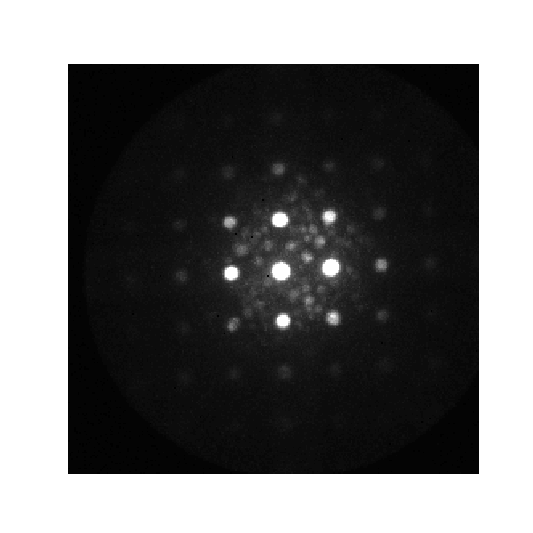

In [8]:
dp_max = np.max(dc_1.data, axis = (0,1))
fig, ax = py4DSTEM.visualize.show(dp_max, returnfig = True)
ax.axis('off')
plt.show()

In [8]:
#fig.savefig('max_dp_full.svg', format='svg', dpi=1200)

### b. Get origins

In [9]:
dc_b = py4DSTEM.io.DataCube(dc_1.data)

In [52]:
coords = py4DSTEM.io.datastructure.Coordinates(dc_b.R_Nx,dc_b.R_Ny,
                                                   dc_b.Q_Nx,dc_b.Q_Ny,
                                                   name='coordinates_calibrationdata')

In [53]:
DP = dc_b.data[5,5]
r, _, _ = py4DSTEM.process.calibration.origin.get_probe_size(DP)

In [54]:
qx0_meas,qy0_meas = py4DSTEM.process.calibration.origin.get_origin(dc_b, r)
py4DSTEM.visualize.show_image_grid(
    get_ar=lambda i:[qx0_meas,qy0_meas][i],
    H=1,W=2,cmap='RdBu') 

Finding origins: 100%|██████████| 261k/261k [20:42<00:00, 210DP/s] 


<IPython.core.display.Javascript object>

In [55]:
# Fit a plane to qx0 and qy0 with robust fitting
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = py4DSTEM.process.calibration.fit_origin(
    qx0_meas = qx0_meas,
    qy0_meas = qy0_meas,
    fitfunction='plane',
    robust = True)
py4DSTEM.visualize.show_image_grid(
    lambda i:[qx0_meas,qx0_fit,qx0_residuals,
              qy0_meas,qy0_fit,qy0_residuals][i],
    H=2,W=3,cmap='RdBu')

<IPython.core.display.Javascript object>

In [56]:
# Store the origin position
coords.set_origin(qx0_fit,qy0_fit)

In [16]:
# Delete datacube with center beam - only needed for accurate localization of center beam since beamstop is in
del dc_b

# 2. Feature Extraction Step - Probe Kernel, Disk Registration, and Universal/Mask Thresholding
## This section includes preparing the probe kernel then detecting and filtering the disks in each pattern

### a. Probe Kernel Creation (from 5x5 scan over carbon film)

In [15]:
cb_sig = hs.load('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/20180727_112544-9cmCL-4Mx-central_beam.hdf5')

In [16]:
dc_p = py4DSTEM.io.DataCube(cb_sig.data[::10,::10])
probe =py4DSTEM.process.diskdetection.probe.get_probe_from_vacuum_4Dscan(dc_p)

fig, ax = py4DSTEM.visualize.show(dp_max, returnfig = True)
ax.axis('off')
plt.show()

100%|██████████| 2703/2703 [00:35<00:00, 76.83it/s]


<IPython.core.display.Javascript object>

In [17]:
# Create probe kernel
r, _, _ = py4DSTEM.process.calibration.origin.get_probe_size(probe.data)
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(probe.data,ri=r*1.2,ro=r*2.4, type='logistic')

In [18]:
# Display probe_kernel, with line profile

rad=50
lineprofile_length=200
lineprofile_width=2

#xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dp_crop.Q_Nx,dp_crop.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax11,ax12,ax13)=plt.subplots(1,3,figsize=(18,5))
ax11.matshow(probe_kernel[:rad,:rad], cmap ='gray')
ax12.plot(np.arange(len(line_profile)),line_profile)
ax13.plot(np.arange(len(line_profile)),line_profile)
ax13.set_ylim(-0.001,0.001)
ax13.set_xlim(150,250)

plt.show()

<IPython.core.display.Javascript object>

### b. Disk Detection

In [19]:
im = np.sum(dc_1.data, axis = (2,3))

<IPython.core.display.Javascript object>


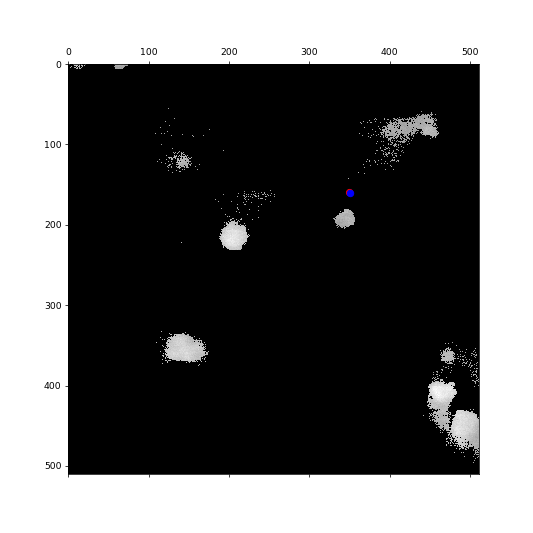

<IPython.core.display.Javascript object>


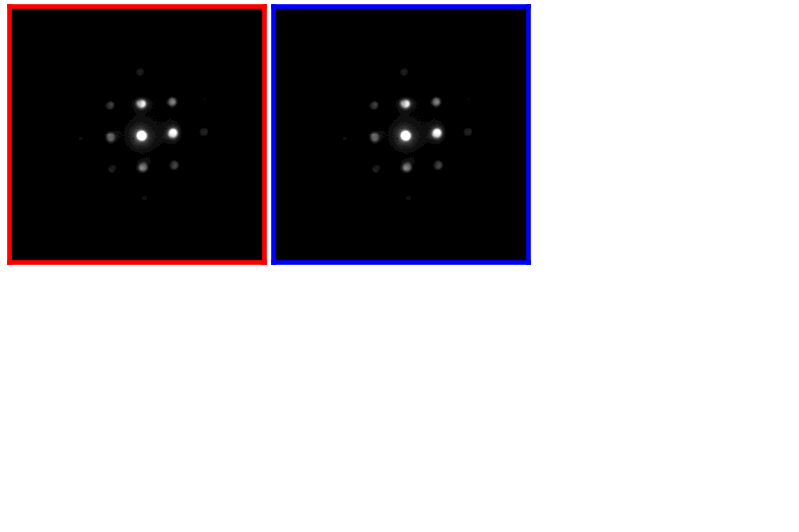

In [29]:
# Select a few DPs

Rxs=np.array((160,161))
Rys=np.array((350,351))

colors = ['r','b']

py4DSTEM.visualize.show_points(im,x=Rxs,y=Rys,pointcolor=colors,figsize=(8,8))
py4DSTEM.visualize.show_image_grid(get_ar=lambda i:dc_1.data[Rxs[i],Rys[i],:,:],
                                   H=2,W=3,get_bordercolor=lambda i:colors[i],scaling='power', power = 0.5)

In [30]:
# Get peaks
corrPower= 1.0
sigma=0.2
edgeBoundary=5
minAbsoluteIntensity=1
minPeakSpacing=2
maxNumPeaks=60
subpixel='multicorr'
upsample_factor=16

peaks = py4DSTEM.process.diskdetection.diskdetection.find_Bragg_disks_selected(
    dc_1,
    probe_kernel,
    Rxs,
    Rys,
    corrPower=corrPower,
    sigma=sigma,
    edgeBoundary=edgeBoundary,
    minAbsoluteIntensity=minAbsoluteIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel = subpixel,
    upsample_factor = upsample_factor)

In [31]:
py4DSTEM.visualize.show_image_grid(
    get_ar=lambda i:dc_1.data[Rxs[i],Rys[i],:,:],H=2,W=3,
    get_bordercolor=lambda i:colors[i],
    get_x=lambda i:peaks[i].data['qx'],
    get_y=lambda i:peaks[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    scaling='power',
    power=0.3,
    open_circles=True,
    scale=200
    )

<IPython.core.display.Javascript object>

In [72]:
disks = py4DSTEM.process.diskdetection.diskdetection.find_Bragg_disks_serial(
    dc_b,
    probe_kernel,
    corrPower=corrPower,
    sigma=sigma,
    edgeBoundary=edgeBoundary,
    minAbsoluteIntensity=minAbsoluteIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel = subpixel,
    upsample_factor = upsample_factor)

Finding Bragg Disks: 100%|██████████| 261k/261k [12:25:09<00:00, 5.84DP/s]   


In [25]:
fp_save = "/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/kernel_disks_coords.h5"

In [26]:
disks = py4DSTEM.io.read(fp_save, data_id = 'braggpeaks_raw')

Reading PointListArray: 100%|██████████| 261121/261121 [00:42<00:00, 6103.34PointList/s]


In [37]:
peaks[0]

In [38]:
aoi = np.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AreaOfInterest.npy')

In [40]:
plt.figure()
plt.imshow(aoi)

<IPython.core.display.Javascript object>

In [47]:
for c in np.array(np.where(aoi ==1)).T:
    disks.pointlists[c[0]][c[1]] = peaks[0]

In [57]:
bp_centered = py4DSTEM.process.calibration.origin.center_braggpeaks(braggpeaks = disks, coords = coords)

<IPython.core.display.Javascript object>


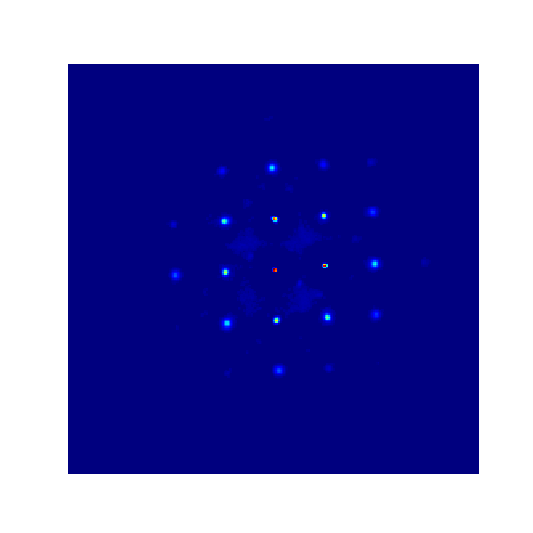

In [58]:
bvm = py4DSTEM.process.diskdetection.braggvectormap.get_bragg_vector_map(bp_centered, dc_b.Q_Nx, dc_b.Q_Ny)

power = 0.25
fig, ax = plt.subplots(figsize = (8,8))
ax.matshow(bvm**power, cmap='jet')
ax.axis('off')
plt.show()

<IPython.core.display.Javascript object>


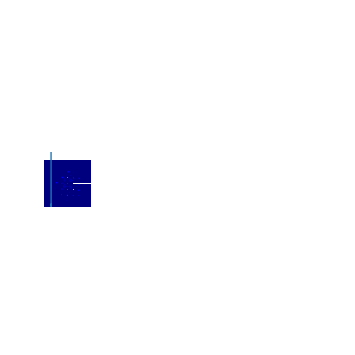

In [59]:
# Create Beamstop mask
x0_,y0_= 130, 130

width = 2
spanned_angle = 2  # degrees
rotation = 91     # degrees
x0_c,y0_c = 0,15
circlemask_radius = 2

beamstopmask_1 = datacube_operations.make_beamstop_mask(Q_Nx, Q_Ny, x0_,y0_,rotation,spanned_angle,width,x0_c,y0_c,circlemask_radius)
beamstopmask_2 = np.invert(beamstopmask_1)
dp_masked_1 = np.ma.array(data=bvm, mask=beamstopmask_1==False)

fig, ax1 = plt.subplots(figsize=(8,8))
ax1.matshow(dp_masked_1**power, cmap='jet')
ax1.axis('off')
#ax2.axis('off')
plt.show()

### c. Universal Thresholding

In [60]:
disks_ar = py4DSTEM.process.diskdetection.diskdetection.get_pointlistarray_intensities(bp_centered)

Getting disk intensities: 100%|██████████| 261k/261k [1:26:54<00:00, 50.1DP/s]


In [61]:
disks_min = np.min(disks_ar)
disks_max = np.max(disks_ar)
disks_hist, bins_edges_disks = np.histogram(disks_ar, bins = 1000, range = (disks_min, disks_max))
bin_width_disks = bins_edges_disks[1] - bins_edges_disks[0]
bin_centers_disks = bins_edges_disks[:-1] + bin_width_disks/2

In [62]:
plt.plot(bin_centers_disks, disks_hist)
plt.xlim((0,1500))
plt.ylim(0, 300)
plt.show()

In [ ]:
minIntensity = 0.01
metric = 'manual'

pointlistarray = datacube_operations.universal_threshold(
    bp_centered, 
    coords = coords, 
    minIntensity=minIntensity,
    metric=metric, 
    )

pointlistarray_ar = py4DSTEM.process.diskdetection.diskdetection.get_pointlistarray_intensities(pointlistarray)

100%|██████████| 261121/261121 [00:02<00:00, 99733.07it/s] 
Getting disk intensities:  44%|████▍     | 116k/261k [18:12<45:43, 53.0DP/s]  

In [98]:
PLA_min = np.min(pointlistarray_ar)
PLA_max = np.max(pointlistarray_ar)

hist_PLA, bins_PLA = np.histogram(pointlistarray_ar, bins = 1000, range = (PLA_min,PLA_max))

bin_width_PLA = bins_PLA[1] - bins_PLA[0]
bin_centers_PLA = bins_PLA[:-1] + bin_width_PLA/2

In [99]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(bin_centers_disks, disks_hist)
ax1.set(xlim = (0,1500), ylim = (0,400))
ax2.plot(bin_centers_PLA, hist_PLA)
ax2.set(xlim = (0,1500), ylim = (0,400))
ax1.set_title('Original Distribution')
ax2.set_title('Thresholded Distribution')
plt.show()

<IPython.core.display.Javascript object>

#### Check BVM to insure false positives around beamstop are reduced

In [101]:
bvm_thresh = py4DSTEM.process.diskdetection.braggvectormap.get_bragg_vector_map(pointlistarray, dc_b.Q_Nx, dc_b.Q_Ny)

<IPython.core.display.Javascript object>


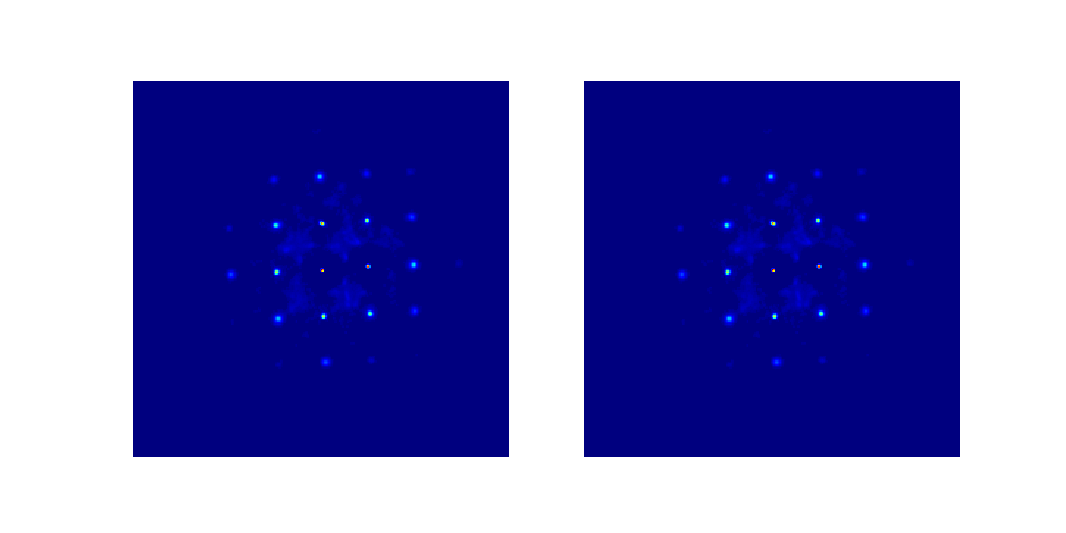

In [102]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16, 8))
ax1.matshow(bvm**power, cmap='jet')
ax2.matshow(bvm_thresh**power, cmap='jet')
ax1.axis('off')
ax2.axis('off')
plt.show()

# 3. Calibration Step - Elliptical correction from PointListArray
## This section includes correcting elliptical distortions from the detected disks

### a. Elliptical Calibration

<IPython.core.display.Javascript object>


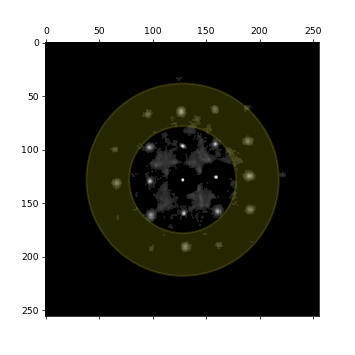

In [106]:
# Select fitting region
qmin,qmax = 50,90
py4DSTEM.visualize.show(bvm_thresh,cmap='gray',scaling='power', power = 0.1,
                        annulus={'center':(dc_b.Q_Nx/2.,dc_b.Q_Ny/2.),
                                 'Ri':qmin,'Ro':qmax,'fill':True,'color':'y','alpha':0.2})

<IPython.core.display.Javascript object>


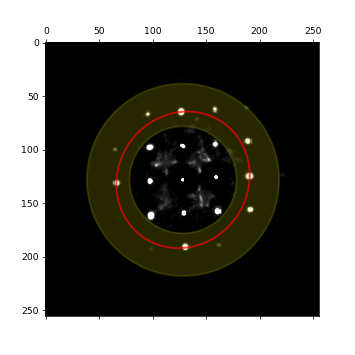

In [107]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.ellipse.fit_ellipse_1D(
                        ar = bvm_thresh,
                        center = (dc_b.Q_Nx/2.,dc_b.Q_Ny/2.),
                        fitradii=(qmin,qmax))
py4DSTEM.visualize.show_elliptical_fit(
    ar = bvm_thresh,
    fitradii = (qmin, qmax),
    p_ellipse=p_ellipse,
    cmap='gray',
    scaling='power',
    power=0.5,
    clipvals='manual',
    min=0,
    max=500,
    fill=True)

<IPython.core.display.Javascript object>


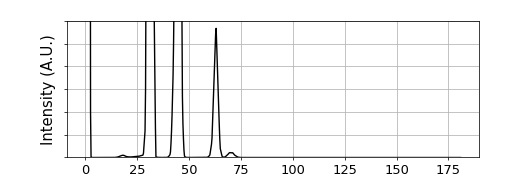

In [108]:
# Radial integration
ymax = 1.5e5
dq=0.25             # binsize for the x-axis

q,I_radial = py4DSTEM.process.utils.radial_integral(
                        bvm_thresh,dc_b.Q_Nx/2,dc_b.Q_Ny/2,dr=dq)
py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax)

<IPython.core.display.Javascript object>


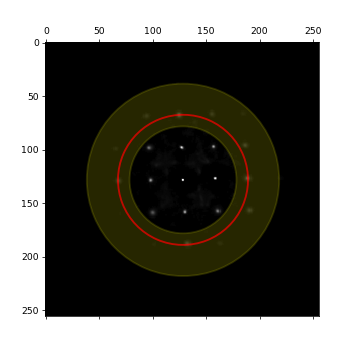

In [109]:
# Confirm that elliptical distortions have been removed

# Correct bragg peak positions, stretching the elliptical semiminor axis to match the semimajor axis length
braggpeaks_ellipsecorr = py4DSTEM.process.calibration.correct_braggpeak_elliptical_distortions(
                                            pointlistarray,p_ellipse)

# Recompute the bvm
bvm_ellipsecorr = py4DSTEM.process.diskdetection.braggvectormap.get_bragg_vector_map(
                            braggpeaks_ellipsecorr,dc_b.Q_Nx,dc_b.Q_Ny)

# Fit an ellipse to the elliptically corrected bvm
qx0_corr,qy0_corr,a_corr,e_corr,theta_corr = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_ellipsecorr,
    center = (p_ellipse[0], p_ellipse[1]),
    fitradii=(qmin,qmax))
py4DSTEM.visualize.show_elliptical_fit(
    bvm_ellipsecorr,
    fitradii = (qmin, qmax),
    p_ellipse = (qx0_corr,qy0_corr,a_corr,e_corr,theta_corr),
    cmap='gray',
    scaling='power',
    power = 0.25,
    fill=True)

# Print the ratio of the semi-axes before and after correction
# print("The ratio of the semiminor to semimajor axes was measured to be")
# print("")
# print("\t{:.2f}% in the original data and".format(100*b))
# print("\t{:.2f}% in the corrected data.".format(100*e_corr))

<IPython.core.display.Javascript object>


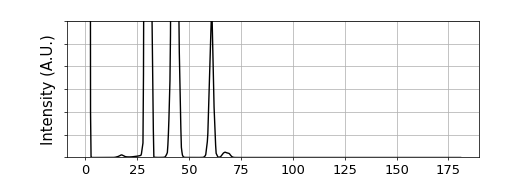

In [110]:
# Radial integration
ymax = 1.5e5
dq=0.25             # binsize for the x-axis

q,I_radial = py4DSTEM.process.utils.radial_integral(
                        bvm_ellipsecorr,dc_b.Q_Nx/2,dc_b.Q_Ny/2,dr=dq)
py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax)

### b. Save all calibrations and PointListArray
#### origin detection and elliptical correction in coordinates object, Bragg disks (calibrated), and probe kernel used to detect disks

In [111]:
# Save to Coordinates
coords.set_ellipse(p_ellipse[2], p_ellipse[3], p_ellipse[4])

In [112]:
probe_kernel_data = py4DSTEM.io.datastructure.diffraction.DiffractionSlice(data=probe_kernel,name = 'probe_kernel')
coords.name = 'coordinates'

In [113]:
fp_save = "/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/kernel_disks_coords.h5"
data = [probe_kernel_data, disks, bp_centered, braggpeaks_ellipsecorr, coords]
py4DSTEM.io.native.write.save(fp_save, data, overwrite = False)

  0%|          | 557/261121 [00:00<00:46, 5566.41it/s]

Saving DiffractionSlice 'probe_kernel'...
Saving PointListArray 'braggpeaks_raw'...


  0%|          | 598/261121 [00:00<00:43, 5976.20it/s]

Saving PointListArray 'braggpeaks_centered'...


  0%|          | 622/261121 [00:00<00:41, 6215.23it/s]

Saving PointListArray 'braggpeaks_centered_ellipsecorrected'...


100%|██████████| 261121/261121 [00:42<00:00, 6124.74it/s]

Saving Coordinates 'coordinates'...


In [9]:
fp_save = "/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/kernel_disks_coords.h5"
probe_kernel_data= py4DSTEM.io.read(fp_save, data_id = 'probe_kernel')
bp_centered = py4DSTEM.io.read(fp_save, data_id = 'braggpeaks_centered')
braggpeaks_ellipsecorr= py4DSTEM.io.read(fp_save, data_id = 'braggpeaks_centered_ellipsecorrected')
disks = py4DSTEM.io.read(fp_save, data_id = 'braggpeaks_raw')
coords = py4DSTEM.io.read(fp_save, data_id = 'coordinates')

Reading PointListArray: 100%|██████████| 261121/261121 [00:43<00:00, 5946.46PointList/s]


### c. Represent Bragg Disks in a set of feature vectors

In [38]:
import featurization

In [39]:
bins_x, bins_y = 4,4

In [40]:
pointlist_transform = featurization.rasterize_peaks(braggpeaks_ellipsecorr, bins_x = bins_x, bins_y = bins_y, Q_Nx = Q_Nx, Q_Ny = Q_Ny, coords = coords)

100%|██████████| 261121/261121 [00:54<00:00, 4801.56it/s]


In [41]:
plt_rs = pointlist_transform.reshape(R_Nx*R_Ny, pointlist_transform.shape[2])

In [44]:
#Pattern 292 for corr 12
#Pattern 127 for corr 18

Rx, Ry = Rxs[1], Rys[1]
Bins = bins_x
binned = 1.
Ry_plt = (Rx % R_Ny)
Rx_plt = np.floor(Rx / R_Ny)
nx_ = int(Q_Nx / Bins)
ny_ = int(Q_Ny / Bins)
bin_size_x = bins_x
bin_size_y = bins_y

<IPython.core.display.Javascript object>


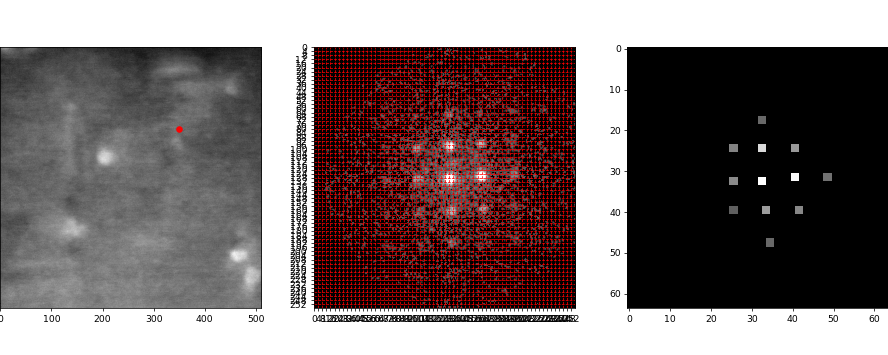

In [45]:
import matplotlib.ticker as plticker

power = 0.3
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax1.imshow(im, cmap = 'gray')
ax1.scatter(Ry, Rx,color='r')

loc_ax2 = plticker.MultipleLocator(base=Bins)
ax2.xaxis.set_major_locator(loc_ax2)
ax2.yaxis.set_major_locator(loc_ax2)
ax2.grid(which='major', axis='both', linestyle='--', color = 'r')
ax2.imshow(dc_1.data[Rx,Ry]**power, cmap = 'gray')
nx_ax2=abs(int(float(ax2.get_xlim()[1]-ax2.get_xlim()[0])/float(bin_size_x)))
ny_ax2=abs(int(float(ax2.get_ylim()[1]-ax2.get_ylim()[0])/float(bin_size_y)))
for j in range(ny_ax2):
    y=Bins/2+j*Bins
    for i in range(nx_ax2):
        x=Bins/2.+float(i)*Bins
        #ax2.text(x,y,'{:d}'.format(i+j*nx_),color='w',ha='center',va='center')
        
ax3.imshow(pointlist_transform[Rx, Ry].reshape(nx_,ny_)**power, cmap = 'gray')
nx_ax3=abs(int(float(ax3.get_xlim()[1]-ax3.get_xlim()[0])))
ny_ax3=abs(int(float(ax3.get_ylim()[1]-ax3.get_ylim()[0])))
for j in range(ny_ax3):
    y=j*binned
    for i in range(nx_ax3):
        x=i*binned
        #ax3.text(x,y,'{:d}'.format(i+j*nx_),color='r',ha='center',va='center')

plt.show()

In [120]:
path_BP = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/BP_centered_EC_Bin4x4_2022.02.16.npy'
np.save(path_BP, plt_rs)

# 4. Feature Extraction Step - Polar Elliptical Transformation and Statistical Extractions
## This section involves transforming the data into polar elliptical form and extracting statistical measurements across each radial bin

### a. Polar Elliptical Transformation

In [10]:
from py4DSTEM.process.utils.elliptical_coords import cartesian_to_polarelliptical_transform

In [15]:
# Polar-elliptical transform of the average diffraction pattern

power = 0.5
ind = 2

PET,rr,tt = cartesian_to_polarelliptical_transform(
    cartesianData=dc_1.data[Rxs[ind],Rys[ind]],
    p_ellipse=(coords.qx0[Rxs[ind],Rys[ind]], coords.qy0[Rxs[ind],Rys[ind]], coords.a,coords.b,coords.theta),
    dr=1,
    dphi=np.radians(1),
    r_range=[0,100],
)

# Show
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,12))
ax1.matshow(dc_1.data[Rxs[ind],Rys[ind]]**power, cmap = 'gray')
ax2.matshow(PET.data**power, cmap = 'gray')
ax3.matshow(PET.mask, cmap = 'gray')
#ax1.axis('off')
#ax2.axis('off')
#ax3.axis('off')
plt.show()

<IPython.core.display.Javascript object>

In [16]:
pet_all = datacube_operations.polar_elliptical_transform_datacube(
    dc_b,
    dr = 1,
    dphi = np.radians(1),
    r_range = [0,100],
    coords = coords,)

Transforming: 100%|██████████| 261k/261k [20:47<00:00, 209DP/s] 


In [17]:
pet_dc = py4DSTEM.io.datastructure.DataCube(pet_all)

<IPython.core.display.Javascript object>


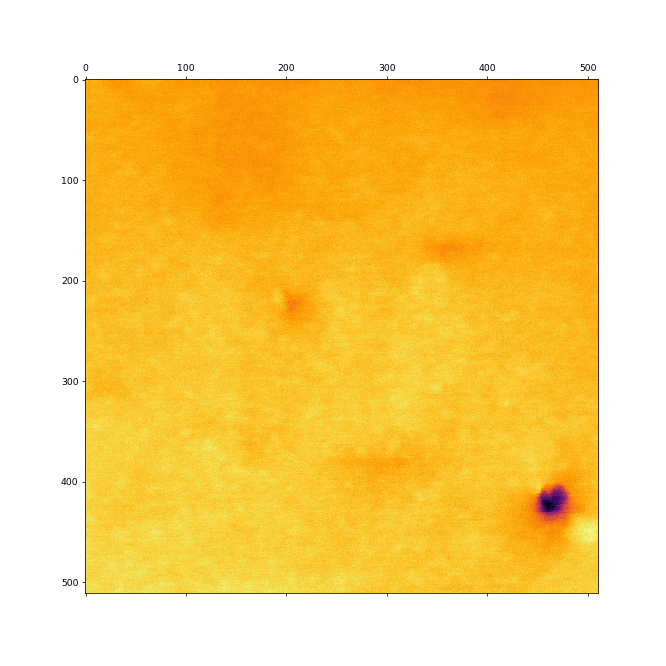

In [18]:
im_pet = np.mean(pet_dc.data,axis=(2,3)) 
fig,ax = plt.subplots(figsize = (10,10))
ax.matshow(im_pet, cmap = 'inferno')
plt.show()

In [19]:
fig,((ax11,ax12,ax13,ax21,ax22,ax23, ax31))=plt.subplots(1,7,figsize=(20,40))
ax11.matshow(im, cmap = 'gray')
ax11.scatter(Rys, Rxs,color=colors)
ax12.matshow(pet_dc.data[Rxs[0],Rys[0]]**power, cmap = 'gray')
ax13.matshow(pet_dc.data[Rxs[1],Rys[1]]**power, cmap = 'gray')
ax21.matshow(pet_dc.data[Rxs[2],Rys[2]]**power, cmap = 'gray')
ax22.matshow(pet_dc.data[Rxs[3],Rys[3]]**power, cmap = 'gray')
ax23.matshow(pet_dc.data[Rxs[4],Rys[4]]**power, cmap = 'gray')
ax31.matshow(pet_dc.data[Rxs[5],Rys[5]]**power, cmap = 'gray')

ax11.axis('off')
ax12.axis('off')
ax13.axis('off')
ax21.axis('off')
ax22.axis('off')
ax23.axis('off')
ax31.axis('off')
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
#del dc_1

### b. Statistical Measurements as a function of r

In [20]:
pet_max = np.max(pet_dc.data, axis=(0,1))

In [21]:
pet_ma = np.ma.array(data = pet_max, mask = PET.mask)
std_test = pet_ma.std(axis = 0)
rp_test = pet_ma.sum(axis = 0)    

<IPython.core.display.Javascript object>


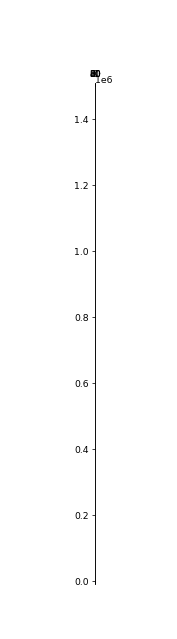

In [22]:
plt.matshow(pet_ma)

In [23]:
plt.plot(rp_test)
plt.show()

In [24]:
mins = scipy.signal.argrelmin(rp_test)[0]
print(mins)

[14 23 40 60 83 87 90 93]


In [25]:
i1, o1 = mins[0], mins[1]
i2, o2 = mins[1], mins[2]
i3, o3 = mins[2],mins[3]
i4, o4 = mins[3], mins[4]

plt.plot(rp_test)
plt.ylim(0,1.5e6)
plt.vlines((i1, o1), 0, 1.5e6, colors = 'r', alpha = 0.5)
plt.vlines((i2,o2), 0, 1.5e6, colors = 'b', alpha = 0.5)
plt.vlines((i3,o3), 0, 1.5e6, colors = 'pink', alpha = 0.5)
plt.vlines((i4,o4), 0, 1.5e6, colors = 'orange', alpha = 0.5)
plt.show()

In [26]:
from py4DSTEM.process.utils import tqdmnd

std_stack = np.zeros([pet_all.shape[0], pet_all.shape[1], pet_all.shape[3]])
var_stack = np.zeros([pet_all.shape[0], pet_all.shape[1], pet_all.shape[3]])
rp_stack = np.zeros([pet_all.shape[0], pet_all.shape[1], pet_all.shape[3]])
for (Rx, Ry) in tqdmnd(pet_all.shape[0], pet_all.shape[1]):
    pet_ma = np.ma.array(data = pet_all[Rx, Ry], mask = PET.mask)
    std_stack[Rx, Ry, :] = pet_ma.std(axis = 0)
    var_stack[Rx, Ry, :] = pet_ma.var(axis = 0)
    rp_stack[Rx, Ry, :] = pet_ma.sum(axis = 0)

100%|██████████| 261121/261121 [05:05<00:00, 853.94it/s]


In [27]:
std_stack_rs = std_stack.reshape(R_Nx * R_Ny, std_stack.shape[2])
var_stack_rs = var_stack.reshape(R_Nx * R_Ny, var_stack.shape[2])
rp_stack_rs = rp_stack.reshape(R_Nx * R_Ny, rp_stack.shape[2])

In [28]:
print(std_stack_rs.shape)
print(var_stack_rs.shape)
print(rp_stack_rs.shape)

(261121, 100)
(261121, 100)
(261121, 100)


In [29]:
np.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/ptransform_std_2022.02.16.npy', std_stack_rs)
np.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/ptransform_var_2022.02.16.npy', var_stack_rs)
np.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/radial_profile_2022.02.16.npy', rp_stack_rs)

<IPython.core.display.Javascript object>


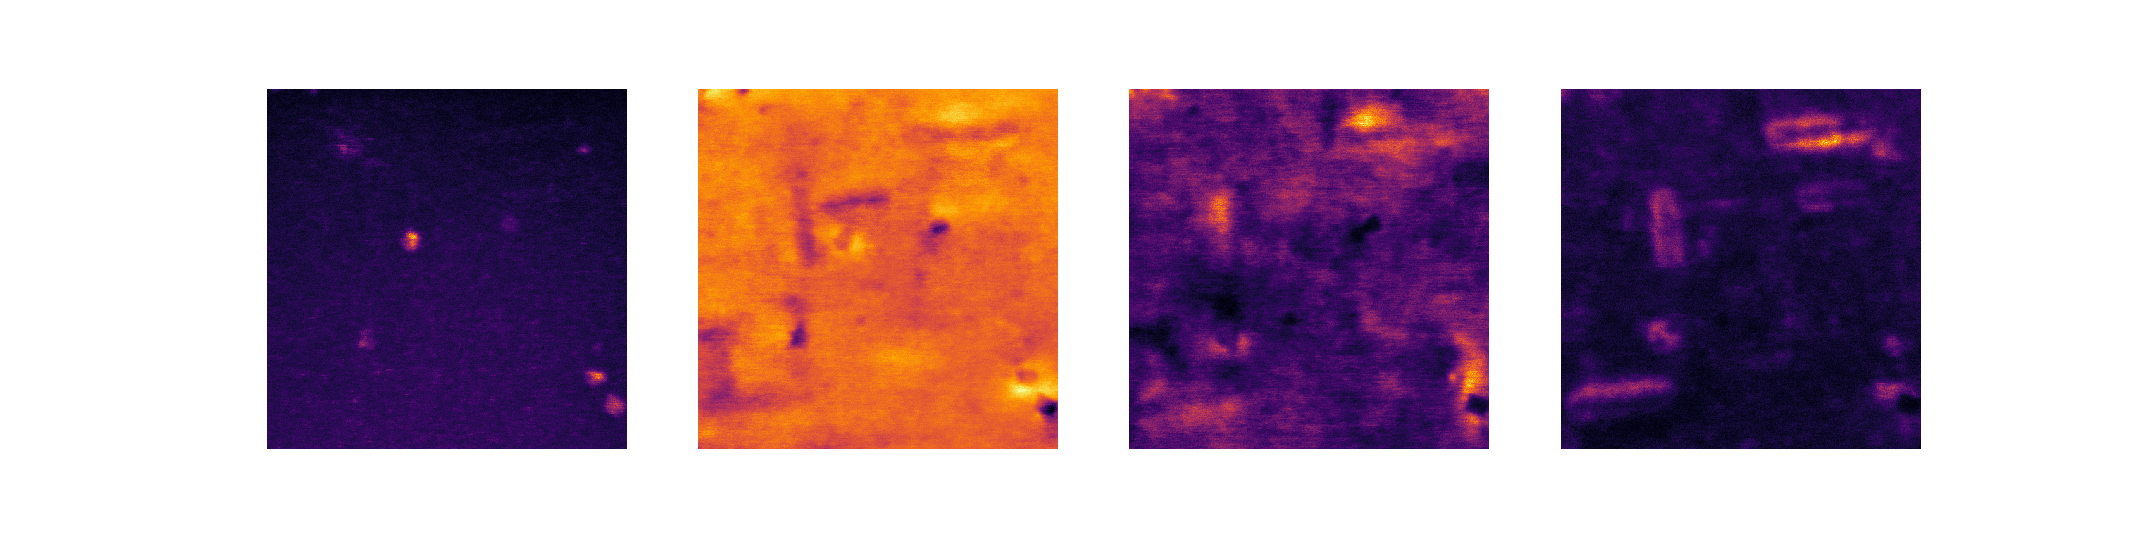

In [30]:
# Visualize radial variance feature maps over ring 1, 2, 3, 4
import matplotlib as mpl
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mpl.cm.ScalarMappable(norm, cmap) 

fig,(ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize = (32,8))
ax1.matshow(np.mean(var_stack[:,:,i1:o1],axis=(2))**0.5, cmap = cmap)
ax2.matshow(np.mean(var_stack[:,:,i2:o2],axis=(2))**0.5, cmap = cmap)
ax3.matshow(np.mean(var_stack[:,:,i3:o3],axis=(2))**0.5, cmap = cmap)
ax4.matshow(np.mean(var_stack[:,:,i4:o4],axis=(2))**0.5, cmap = cmap)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
plt.show()

In [31]:
#First Ring
std_dc_av = np.sum(std_stack, axis = 2)
#second ring
var_dc_av = np.sum(var_stack, axis = 2)
#third ring
rp_dc_av = np.sum(rp_stack, axis = 2)

<IPython.core.display.Javascript object>


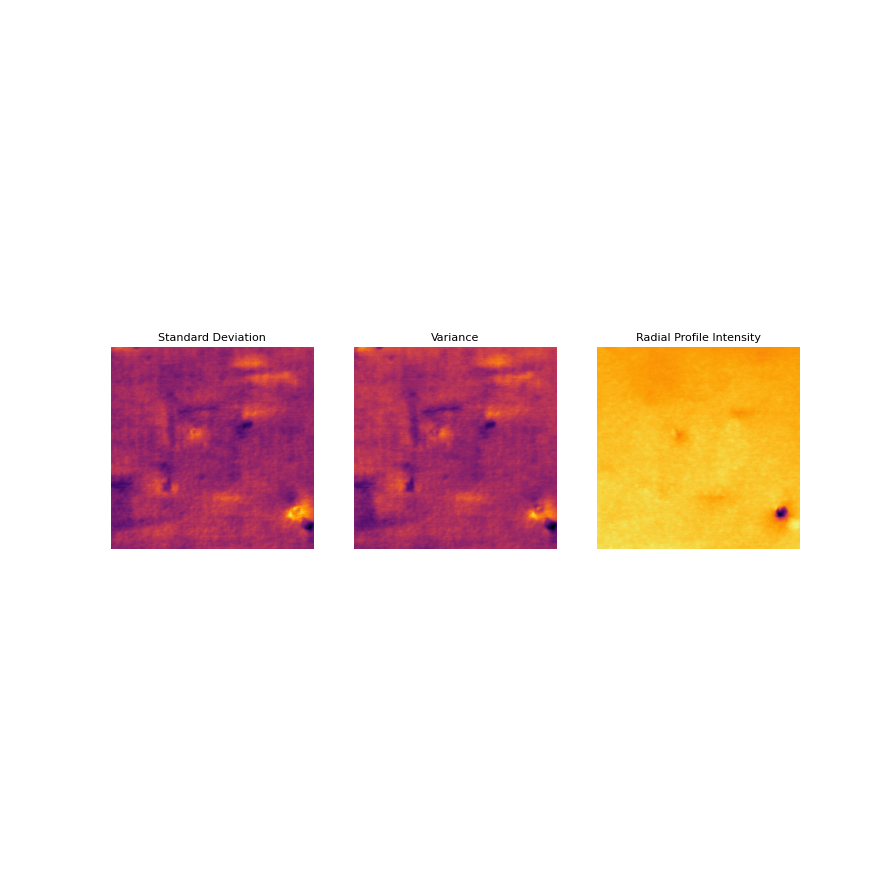

In [32]:
fig, ((ax11, ax12, ax13)) = plt.subplots(1,3, figsize = (20,20))
ax11.imshow(std_dc_av.reshape(R_Nx,R_Ny), cmap = cmap)
ax12.imshow(var_dc_av.reshape(R_Nx,R_Ny), cmap = cmap)
ax13.imshow(rp_dc_av.reshape(R_Nx,R_Ny), cmap = cmap)
#fig.colorbar(mpl.cm.ScalarMappable(norm, cmap))
ax11.set_title('Standard Deviation')
ax12.set_title('Variance')
ax13.set_title('Radial Profile Intensity')

ax11.axis('off')
ax12.axis('off')
ax13.axis('off')
plt.show()

# 5. Feature Extraction Step - Angular Averaging (Mean Virtual Imaging)
## This section includes the extraction of the "Angular Average" which is series of mean virtual images across the detected peaks in the radial integral

<IPython.core.display.Javascript object>


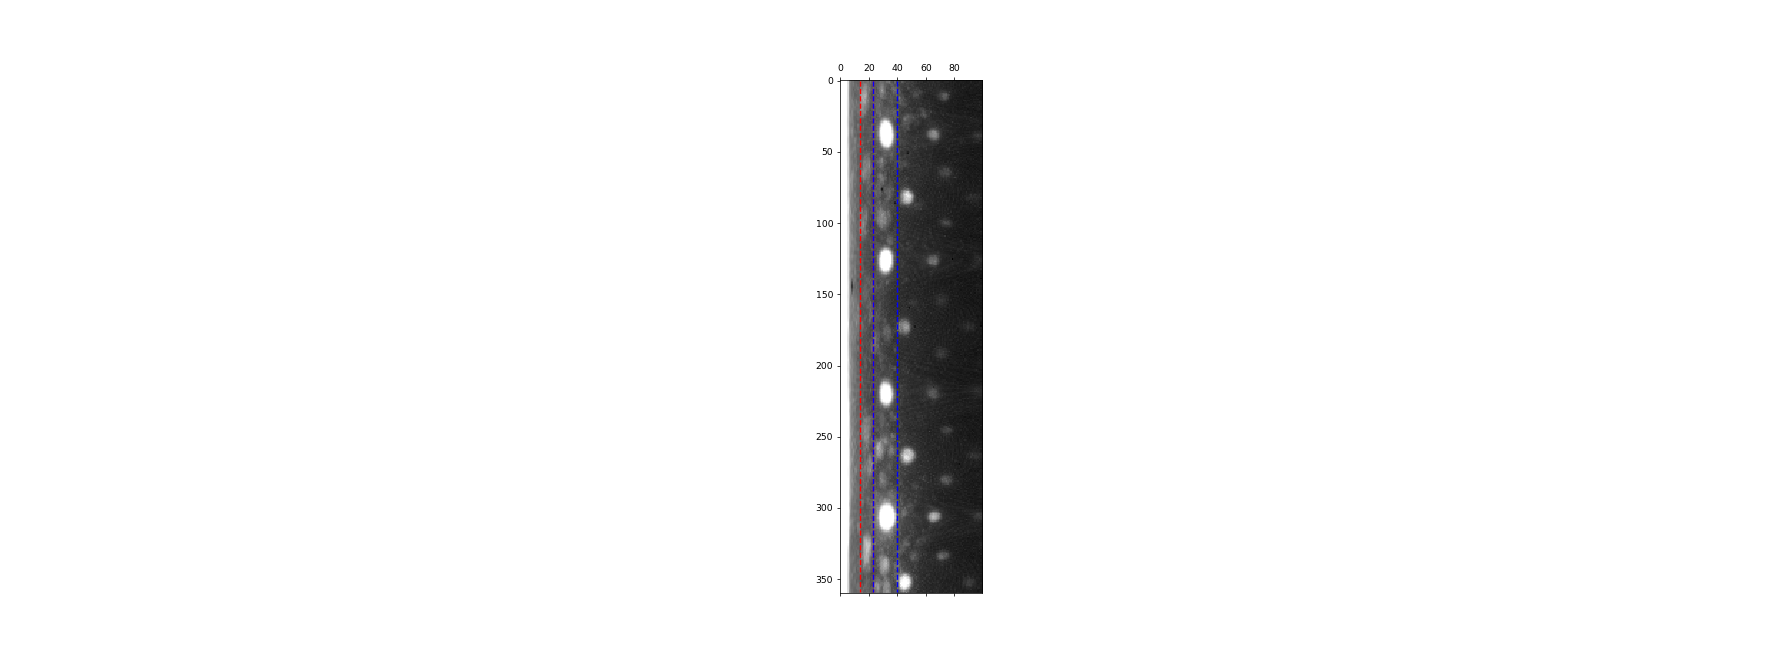

In [33]:
fig,ax = plt.subplots(figsize = (40,15))
ax.matshow(pet_max**0.5, cmap = 'gray')
ax.vlines((i1, o1),0,359, color = 'r', ls = '--')
ax.vlines((i2, o2),0,359, color = 'b', ls = '--')
plt.show()

In [34]:
start = 0
interval = 5 # averaging interval
fraction = 1
n = np.int64(((360/fraction)-start)/interval)
norm = mpl.colors.Normalize(vmin=0, vmax=n)
cmap_base = mpl.cm.get_cmap('plasma')
mappable = mpl.cm.ScalarMappable(norm, cmap_base)
mappable.set_array([])
mappable.set_clim(-0.5, n+1+0.5)

clist = []
for i in range(n):
    clist.append(mappable.cmap.colors[np.int64(
        np.floor(np.shape(mappable.cmap.colors)[0])/(n)*i)])

rects1 = []
rects2 = []

vis1_np = np.zeros((R_Nx, R_Ny, n))
vis2_np = np.zeros((R_Nx, R_Ny, n))
vis3_np = np.zeros((R_Nx, R_Ny, n))
vis4_np = np.zeros((R_Nx, R_Ny, n))


for i in range(n):
    x_lower = start + i*interval
    x_upper = x_lower + interval
    vi1_temp = np.mean(pet_dc.data[:,:,x_lower:x_upper,i1:o1],axis = (2,3))
    vi2_temp = np.mean(pet_dc.data[:,:,x_lower:x_upper,i2:o2],axis = (2,3))
    vi3_temp = np.mean(pet_dc.data[:,:,x_lower:x_upper,i3:o3],axis = (2,3))
    vi4_temp = np.mean(pet_dc.data[:,:,x_lower:x_upper,i4:o4],axis = (2,3))

    rects1.append((x_lower, x_upper, i1, o1))
    rects2.append((x_lower, x_upper, i2, o2))
    vis1_np[:,:,i] = vi1_temp
    vis2_np[:,:,i] = vi2_temp
    vis3_np[:,:,i] = vi3_temp
    vis4_np[:,:,i] = vi4_temp


In [35]:
fig, ax = py4DSTEM.visualize.show_rectangles(pet_max, 
                                lims=rects1, 
                                color = clist,
                                alpha = 0.8,
                                fill=False,
                                linewidth=2,
                                figsize=(40,15),
                                returnfig = True)
ax.axis('off')
plt.show()

<IPython.core.display.Javascript object>

In [36]:
vis1_rs = vis1_np.reshape(R_Nx*R_Ny, n)
vis2_rs = vis2_np.reshape(R_Nx*R_Ny, n)
vis3_rs = vis3_np.reshape(R_Nx*R_Ny, n)
vis4_rs = vis4_np.reshape(R_Nx*R_Ny, n)

In [37]:
path_aDF_r1 = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/annularDF_5deg_r1_2022.02.16.npy'
path_aDF_r2 = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/annularDF_5deg_r2_2022.02.16.npy'
path_aDF_r3 = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/annularDF_5deg_r3_2022.02.16.npy'
path_aDF_r4 = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/AlexWorkflow/HMA/annularDF_5deg_r4_2022.02.16.npy'
np.save(path_aDF_r1, vis1_rs)
np.save(path_aDF_r2, vis2_rs)
np.save(path_aDF_r3, vis3_rs)
np.save(path_aDF_r4, vis4_rs)